# 0. Introduction: Virtual Patients

Given a set of data about a patient group, we want to produce a way of describing their distribution without revealing individual patient identities. We can do this by releasing a set of 'virtual patients' with the same statistics as the original set, or, ideally by releasing a function which describes their distribution.

Max suggested that inducing inputs provided through sparse GP could be used to provide 'fake' data points, with all of the statistical and structural features of the original data.

Below I consider this, but find that one can still infer patient values using these values. It does however turn out that inducing inputs have properties that might be useful later. Specificially, that they can be placed sufficiently far apart for a later algorithm to operate successfully.

# 1. SparseGP for Privacy

## Why sparse GP doesn't provide enough privacy

Below is an example with just a few data points (and only 3 inducing points).

I look at how easy it is to estimate the Xs given the outputs we will provided.

Populating the interactive namespace from numpy and matplotlib


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f7aa428ad10>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f7aa427c3d0>],
 'inducing_inputs': [<matplotlib.lines.Line2D at 0x7f7aa427c390>]}

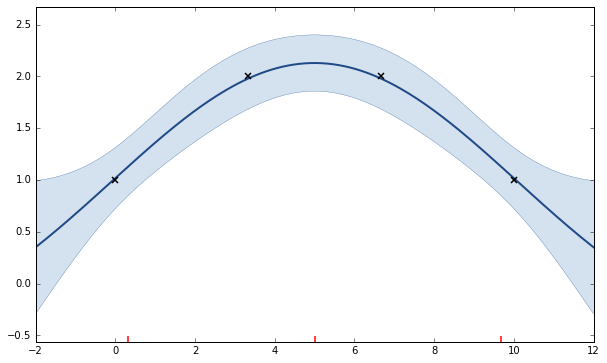

In [4]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

N = 4
M = 3
noise_var = 0.1
X = np.linspace(0,10,N)[:,None]
y = np.hstack([np.linspace(1,2,np.floor(N/2.)),np.linspace(2,1,N-np.floor(N/2.))])
y = y[:,None]
y = y

k = GPy.kern.RBF(1,lengthscale=5.,variance=19.)
Z = np.linspace(0,10,M)[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z)
m.likelihood.variance = noise_var
m.optimize()

m.plot()

In [ ]:
m.kern.K(m.Z, m.X)

### Estimating the inputs...

Can the user infer estimates or values of $X$ and $Y$ from:
$C$,
$\Lambda$,
$\Sigma^{-1}$ or
$Z$?

$C = \beta \Sigma^{-1} K_{UF} Y$

$\Sigma = K_{UU} + \beta K_{UF} K_{FU}$

The user has $\Sigma$ and can find $K_{UU}$ from Z and the kernel. So they have $\beta K_{UF} K_{FU}$.

What is $\beta$? Assume it can be estimated for now?

So they have $K_{UF} K_{FU}$

In [5]:
np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

array([[  7.68807932,   8.18861109,   5.75716185],
       [  8.18861109,  10.0254779 ,   8.18861109],
       [  5.75716185,   8.18861109,   7.68807932]])

**If** they can factorise this (this is the big question, that we'll look at in a second). They'll have:

In [7]:
K_uf = m.kern.K(m.Z, m.X)
print K_uf

[[ 1.84774946  1.64862501  1.11146687  0.56619626]
 [ 1.34975008  1.78631287  1.78631287  1.34975008]
 [ 0.56619626  1.11146687  1.64862501  1.84774946]]


They'll be able to easily infer X, as they know Z and the kernel.

In [9]:
Z

array([[  0.],
       [  5.],
       [ 10.]])

In [10]:
m.rbf.lengthscale.values

array([ 6.29677512])

### Example

Example, distinguishing Z locations from $K_{UF}$ matrix.

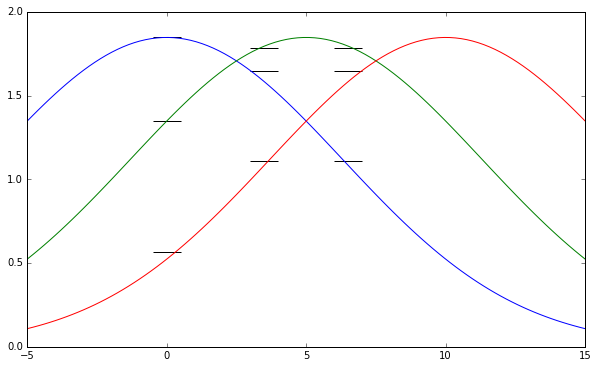

In [11]:
dom = np.linspace(-5,15,100)
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[0])**2/m.rbf.lengthscale.values**2))
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[1])**2/m.rbf.lengthscale.values**2))
plt.plot(dom,1.848*np.exp(-.5*(dom-Z[2])**2/m.rbf.lengthscale.values**2))
plt.hlines(K_uf[:,0],-.5,.5)
plt.hlines(K_uf[:,1],3,4)
plt.hlines(K_uf[:,2],6,7)

So the question is can the $K_{UF} K_{FU}$ matrix be inverted?

It is created by the product of a pair of matrices of the form:

    [      ] x [ ] = [ ]
               [ ]
               [ ] 
               [ ]
               
I.e. wide x long. Which gives a smaller matrix, and loses lots of info. It seems like it should be impossible to factorise to recover the original values.

In [13]:
#Here's an example where we can't recover the original matrix [0,1,2], just by knowing that the sum square is 5.
import numpy as np
U = np.array([0,1,2])
np.dot(U,U.T)

5

In the example above we can't recover that the original matrix was [0,1,2].

However, if we imagine a situation in which one of the inducing inputs was placed at the location of one of the data points, a long way from other data, then the matrix might look like:

In [14]:
#In this case, the correlation of the first inducing input with the data is [.2, .5, 0], 
#ie, it is close to the first two data points.
#The second inducing input is near the third data point, and far from the first two.

U = np.array([[.2,.5,0],[0,0,1]])
print U

[[ 0.2  0.5  0. ]
 [ 0.   0.   1. ]]


In [15]:
np.dot(U,U.T)

array([[ 0.29,  0.  ],
       [ 0.  ,  1.  ]])

We know the locations of the inducing points and so, if we know the largest covariance value that can exist for that kernel (e.g. 1) then we know that one of the original data points was at the location of the second inducing point.

### Can we guess m.X?

Even though the earlier data and inducing points were mixed together, so that there were no zeros in the $K_{uf}$ matrix, it seems it's still possible to guess the locations of X from the $K_{uf} K_{fu}$ matrix and from the locations, $Z$, of the inducing points.

Rather than do anything clever, I just ask scipy to find X from the matrix.

In [16]:
A = np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

import numpy as np
from scipy.optimize import minimize

def cost(B):
    B = B[:,None]
    k = m.kern.K(m.Z, B)
    
    return np.sum((A - np.dot(k,k.T))**2) #sum sqr error



X0 = np.array([9,4,2,10]) #np.linspace(0,1,N)
print cost(X0)
res = minimize(cost, X0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
guesses = np.array(res.values()[4])[:,None]
print guesses
print X

5.35222239776
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 234
         Function evaluations: 410
[[  6.66666667e+00]
 [  4.47718170e-09]
 [  3.33333333e+00]
 [  1.00000000e+01]]
[[  0.        ]
 [  3.33333333]
 [  6.66666667]
 [ 10.        ]]


Clearly it has successfully found the locations of the four data points.

This seems like a trivial example (with only 4 data points, and 3 inducing inputs there's enough dof in the covariance matrix for the information about the data to be preserved)...

To see if this is a problem for a slightly more complicated example,

we consider 7 data points and 3 inducing inputs.

Populating the interactive namespace from numpy and matplotlib
[[ 1.08467875  0.99934974  0.86911716  0.4044152   0.25225269  0.09826947
   0.05625054]
 [ 0.9861845   1.07758881  1.11145639  0.8627345   0.66601447  0.36494172
   0.24774798]
 [ 0.19096424  0.29121384  0.41919531  0.88449694  1.03576004  1.10542459
   1.04732333]]
-0.00
4.06
7.91
20.23
24.67
33.34
36.80
[[  0.]
 [  4.]
 [  8.]
 [ 20.]
 [ 25.]
 [ 33.]
 [ 37.]]
Note that some of the results were estimated, others were not. Those points nearest the inducing inputs were most vulnerable (makes sense?)
  Index  |  sparse_gp.inducing_inputs  |  Constraint  |   Prior   |  Tied to
  [0 0]  |                 -3.6807574  |              |           |    N/A    
  [1 0]  |                  8.1455287  |              |           |    N/A    
  [2 0]  |                  31.256583  |              |           |    N/A    


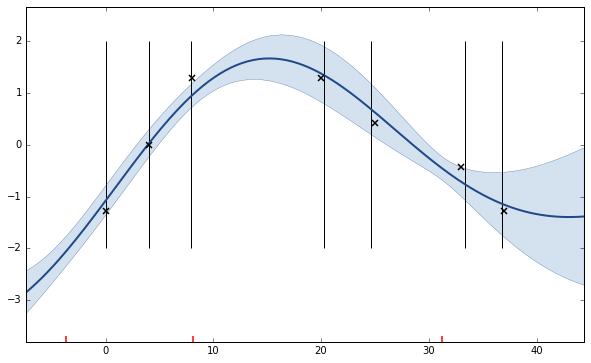

In [49]:
##Just another example, to illustrate that this can happen with more points.

%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

M = 3
X = np.array([0.,4.,8.,20.,25.,33.,37.])[:,None]
N = len(X)
y = np.hstack([np.linspace(1,2,np.floor(N/2.)),np.linspace(2,1,N-np.floor(N/2.))])
y = y - np.mean(y)
y = y / np.std(y)
y = y[:,None]
k = GPy.kern.RBF(1) #,lengthscale=5.,variance=19.)
Z = np.linspace(0,30,M)[:,None]
m = GPy.models.SparseGPRegression(X,y,Z=Z.copy())

m.likelihood.variance = 0.01
m.likelihood.fix()
m.kern.lengthscale = 20
m.optimize()
m.plot()
print m.kern.K(m.Z, m.X)

A = np.dot(m.kern.K(m.Z, m.X),m.kern.K(m.Z, m.X).T)

import numpy as np
from scipy.optimize import minimize

def cost(B):
    B = B[:,None]
    k = m.kern.K(m.Z, B)
    
    return np.sum((A - np.dot(k,k.T))**2) #sum sqr error

X0 = np.linspace(0,30,N)
res = minimize(cost, X0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True, 'maxfev':10000})
guesses = np.array(res.values()[4])[:,None]
for g in guesses:
    print "%0.2f" % g
print X
print "Note that some of the results were estimated, others were not. Those points nearest the inducing inputs were most vulnerable (makes sense?)"
print m.Z
plt.vlines(guesses,-2,2)

In the figure above the vertical lines along the x axis are the locations the search found the data points to be. One can see that for 5 of the 7 data points it correctly estimated their location, using just the three inducing inputs (indicated at the bottom of the image).

In summary, the $K_{fu} K_{uf}$ matrix can leak information about the locations of the data points, even when there are many more inputs than inducing points.

## Summary: How to provide privacy?

There are two problems the above result causes:

1. we can estimate the values of X themselves.
2. we can estimate the values of Y. This will still be uncertain as it'll have a CI surrounding it.

How to fix?

 - Move the values of the training data (add noise to X or Y)
 - Modify the $K_{uf}$ matrix (add noise there)
 - Move the positions of the inducing inputs after $K_{uf}$ is generated.
 
None of these seem ideal. I feel probably adding noise to the matrix might provide the most powerful method, but I'm not completely sure.

# 2. Differential Privacy and GPs, making the inputs private (first attempt)

We are trying to produce a function (or functional) which describes the distribution of data in some private database D. We could use a Gaussian Process to model this data, however earlier notes suggest that, even using inducing points, we can't immediately remove knowledge of the data. However, we could add noise to the data or the function.

The paper "Differential Privacy for Functions" (Hall et al.) offers a method for adding noise to an arbitrary function $f$.

> Using the notation $K_x = K(x, . )$
>
> For two functions $f = \sum^n_{i=1} \theta_i K_{x_i}$ and $g = \sum^m_{j=1} \xi_j K_{y_j}$
> the inner product is given by:
>
> $$\left< f, g \right>_H = \sum_{i=1}^n \sum_{j=1}^m \theta_i \xi_j K(x_i, y_j)$$
>
> and the corresponding norm of $f$ is $||f||_H = \sqrt{ \left< f, f \right>_H }$

> For $f \in H$ where H is the RKHS corresponding to the kernel K, and for any finite sequence $x_1...x_n$ of distinct points in T, we have:

> $||K^{-1/2} f|| \leq ||f||_H$
>
> So the release of:
>
> $\hat{f_D} = f_D + {{\Delta c(\beta)} \over \alpha} G$
>
> is $(\alpha, \beta)$-DP whenever:
>
> $\Delta \geq sup_{D \sim D'} ||f_D - f_{D'}||_H$
>
> **When $G$ is the sample path of a Gaussian process having mean zero and covariance function K, given by the reproducing kernel of H.**

In summary we can make a function private by adding a sample from a Gaussian Process (with kernel equal to the GP we're trying to make private), scaled by a constant.

## Applying this to GPs

In the paper Hall applies this to Kernel Density Estimation. To make our problem more like that, we can use the representer theorem to write the mean function of the GP in a similar form (sum of [weighted] kernels).

### Representer theorem

The mean of the posterior is expressed as:

$$\bar{f_*} = \mathbf{k_*^\top} K^{-1} \mathbf{y}$$

Which can be written as a summation,

$$\bar{f_*} = \sum_{i=1}^N a_i k(\mathbf{x}, \mathbf{x}_i)$$

where $\mathbf{a} = K^{-1} \mathbf{y}$

### Reiteration

How does this help us apply differential privacy?

Section 4.1 of 'Differential Privacy for Functions' provides a method for adding gaussian process samples (as noise) to a function.

I've covered most of the important steps from the paper below, while leaving out the proofs.

We again consider two datasets, which differ in their last value, $n$.

We express our posterior estimate of the mean as:

$$f_D(x) = \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i)$$

where $n$ is the number of elements in $\mathbf{x}$, and $\mathbf{a} = K^{-1} \mathbf{y}$

### Detour to the paper

First I consider the solution in the paper and explain it in more detail, and then I'll look at how to make it applicable to our problem.

For the example in the paper (standard kernel density estimation), the function $f_D(x)$ is:

$$f_D(x) = C \sum_{i=1}^n k(x,x_i)$$

Where $C$ is a normalisation constant.

In the paper, the sensitivity $\Delta$ must be defined to be greater or equal to the distance between $f_D$ and $f_D'$, i.e. $\Delta \geq sup_{D \sim D'} ||f_D - f_D'||_H$.

We want to put an upper bound therefore on $||f_D - f_D'||$.

#### The expression for $f_D(x) - f_D'(x)$

$$f_D(x) - f_D'(x) = C \sum_{i=1}^n k(x,x_i) - C \sum_{i=1}^n k(x,x'_i)$$

when $i \neq n$, $x'_i=x_i$ and the value in the sum of both $f_D$ and $f_D'$ are equal and cancel out. This leaves just the term in the summation when $i=n$.

$$f_D(x) - f_D'(x) = C k(x,x_n) - C k(x,x_n')$$

### Detour to RKHS

What is $||f_D - f_D'||$?

The norm of $g$ is defined to be:

$||g|| = \sqrt{\left< g,g \right>}$

Substituting in our expression:

$||f_D - f_D'||^2 = \left< C k(x,x_n) - C k(x,x_n'), C k(x,x_n) - C k(x,x_n') \right>$

We can use the linear property to 'factorise' the inner product:

$||f_D - f_D'||^2 = \left< C k(x,x_n), C k(x,x_n) \right> - \left< C k(x,x_n), C k(x,x_n') \right> - \left< C k(x,x_n'), C k(x,x_n) \right> + \left< C k(x,x_n'), C k(x,x_n') \right>$

Note that the symmetry property of inner products means the two middle terms are equal. The linear property means we can move the $C$ terms out of the inner products.

$||f_D - f_D'||^2 = C^2 \Big[ \left< k(x,x_n), k(x,x_n) \right> - 2 \left< k(x,x_n), k(x,x_n') \right>  + \left< k(x,x_n'), k(x,x_n') \right> \Big]$

We now use the magic of **Reproducing Kernel Hilbert Spaces**

We can consider the kernel $k(.,x_n)$ to be a functional, returning a different function, depending on the value of $x$. In particular we can write a kernel $k(x,x_n)$ (wrt this free variable $x$) as $k_{x_n}$. So $k_{x_n}(x) = k(x,x_n)$.

The RKHS property says that:

$\left< k_x, k_y \right>_H = k(x,y)$

So we can write $\left< k(x,x_n), k(x,x_n) \right>$ as:

$$\left< k(x,x_n), k(x,x_n) \right> = \left< k_{x_n}, k_{x_n} \right>$$

which we can write using properties of RKHS as:

$$\left< k_{x_n}, k_{x_n} \right> = k(x_n,x_n)$$

So using the same logic to the other terms in the earlier expression;

$$||f_D - f_D'||^2 = C^2 \Big[ k(x_n,x_n) - 2 k(x_n, x_n')  + k(x_n', x_n') \Big]$$

### Back to the paper...

The remaining parts of the paper are quite simple,

The expression $k(x_n,x_n) - 2 k(x_n, x_n')  + k(x_n', x_n')$ is upper bounded by 2 (as each kernel $\leq$ 1).

This means that $||f_D - f_D'||^2 \leq 2 C^2$

This allows us to pick a value for $\Delta = C \sqrt{2}$ which scales the sample drawn from the gaussian process.

### Back to our problem

Can we apply this same logic to our own problem?

We noted that the mean of the GP can be expressed as follows:

$$f_D(x) = \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i)$$

where $\mathbf{a} = K^{-1} \mathbf{y}$

So following the logic of above,

$$f_D(\mathbf{x}) - f_D'(\mathbf{x}) = \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i) - \sum_{i=1}^n a'_i k(\mathbf{x},\mathbf{x}'_i)$$

The immediate problem is that $a_i \neq a'_i$ (for $i \neq n$). So we can't cancel these elements.

If we left them in, what do we get?

$$f_D(\mathbf{x}) - f_D'(\mathbf{x}) = \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i) - a'_i k(\mathbf{x},\mathbf{x}'_i)$$

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \left< \sum_{i=1}^n a_i k(\mathbf{x},\mathbf{x}_i) - a'_i k(x,x'_i), \sum_{i=1}^n a_i k(x,x_i) - a'_i k(x,x'_i) \right>$$

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j \left< k_{\mathbf{x}_i}, k_{\mathbf{x}_j}\right> - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j \left< k_{\mathbf{x}_i}, k_{\mathbf{x}'_j}\right> + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j \left< k_{\mathbf{x}'_i}, k_{\mathbf{x}'_j}\right>$$

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j k(\mathbf{x}_i, \mathbf{x}_j) - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j k(\mathbf{x}_i, \mathbf{x}'_j) + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j k(\mathbf{x}'_i, \mathbf{x}'_j)$$

We note that the kernels are all $\leq 1$, so:

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 \leq \sum_{i=1}^n \sum_{j=1}^n a_i a_j - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j$$


$$||f_D(x) - f_D'(x)||^2 \leq \sum \mathbf{a} \mathbf{a^\top} - 2 \sum \mathbf{a} \mathbf{a'}^{\top} + \sum \mathbf{a'} \mathbf{a'}^\top$$

where these summations are over all elements in the matrix.

$$||f_D(x) - f_D'(x)||^2 \leq \mathbf{1} \mathbf{a} \mathbf{a^\top} \mathbf{1}^\top - 2 \mathbf{1} \mathbf{a} \mathbf{a'}^{\top} \mathbf{1}^\top + \mathbf{1} \mathbf{a'} \mathbf{a'}^\top \mathbf{1}^\top$$

The middle term's in the opposite direction, so we'll remove it.

$$||f_D(x) - f_D'(x)||^2 \leq \mathbf{1} \mathbf{a} \mathbf{a^\top} \mathbf{1}^\top + \mathbf{1} \mathbf{a'} \mathbf{a'}^\top \mathbf{1}^\top$$

Let $G = K^{-1}$

$\Delta^2 \leq \mathbf{1 (a a^\top + a' a'^\top) 1^\top}$

substituting in for $\mathbf{a}$:

$\Delta^2 \leq \mathbf{1} \Big(G \mathbf{y} (G \mathbf{y})^\top + G' \mathbf{y} (G' \mathbf{y})^\top \Big) 1^\top$

$\Delta^2 \leq \mathbf{1} \Big(G \mathbf{y} \mathbf{y}^\top G^\top + G' \mathbf{y} \mathbf{y}^\top G'^\top \Big) 1^\top$

$\Delta^2 \leq \mathbf{1} (G + G') (\mathbf{y} \mathbf{y}^\top) (G + G')^\top 1^\top$

$\Delta^2 \leq \mathbf{1} (G + G') \mathbf{y} \mathbf{y}^\top (G + G')^\top 1^\top$

Note that $ \mathbf{1} (G + G') \mathbf{y}$ is scalar, and identical to the second half, leaving:

$\Delta^2 \leq \Big(\mathbf{1} (G + G') \mathbf{y} \Big)^2$

$\Delta \leq \mathbf{1} (G + G') \mathbf{y}$

Unfortunately this doesn't look any more generalisable. For a given pair of inverse covariance matrices, we have this bound on $\Delta$.

> Thought: Could we use this still to select $\Delta$. One needs to be careful that the value of $\Delta$ doesn't reveal information about the underlying data. A later section in the paper (4.1.2 Private Choice of Bandwidth) handles a similar problem in selecting a value of H. Could we apply a similar idea to the selection of $\Delta$. We need to find a differentially private version of $\hat{\Delta}$?

### Can we put a bound on the values in the $K^{-1}$ matrix?

Important:

After playing with examples of K^-1 (with the rbf kernel), *I found that an upper bound on the sum of the elements in the inverse covariance matrix (for the rbf kernel) is $N$*. **To do: PROVE MATHEMATICALLY!**

This might be because the sum of the eigenvalues of some covariance matrices add up to N. When is this true? **To do: PROVE MATHEMATICALLY!**

If $|\mathbf{y}| \leq y_{max}$ is bounded, and we also bound how close together the values of $\mathbf{x}$ can be. Then the upper bound on the $G \mathbf{y}$ result is equal to $N y_{max}$.

Substituting this in

$\Delta \leq 2 N y_{max}$

## Example

For example, $N = 10$ and $y_{max}=10$.

We must ensure that $x$ is at least a certain distance apart (to be decided).

Substituting into our expression for $\Delta$:

$\Delta \leq 2 \times 10 \times 10 = 200$

Below we have a set of data that we are going to use to constrain a GP. We'll then add the appropriate noise to make it private.

Populating the interactive namespace from numpy and matplotlib
warning in stationary: failed to import cython module: falling back to numpy


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x7f7aa5ca3610>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x7f7aa5cfcc90>],
  [<matplotlib.lines.Line2D at 0x7f7aa5d0ea50>]]}

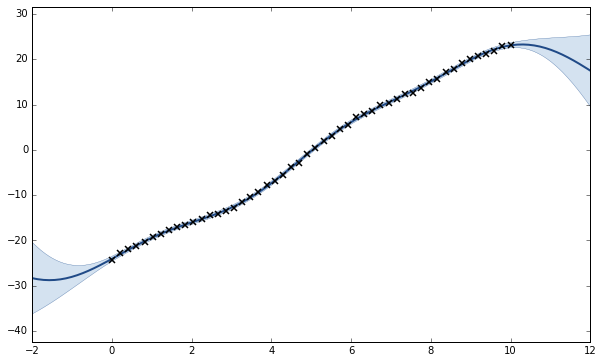

In [1]:
%pylab inline
import GPy
import numpy as np
import matplotlib;matplotlib.rcParams['figure.figsize']=(10,6)
from matplotlib import pyplot as plt
from scipy import optimize

k = GPy.kern.RBF(1)
N = 50
noise_var = 0.001
X = np.linspace(0,10,N)[:,None]
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)
y = y+np.arange(-N/2,N/2,1.)[:,None]

m = GPy.models.GPRegression(X,y)
#m.likelihood.variance = noise_var
m.optimize()

m.plot()

Below we try adding differential privacy to the mean function of the above GP.

With the current bounds, *the amount of noise added is very high* (completely obscures the shape of the function) for a reasonable value of $\alpha$ (often called $\epsilon$). In the example below, instead of this value being of the order of 1, it's of the order of 100s. But hopefully illustrates the idea. Note this value of $alpha$ is too high for proper use.

Below we sample some example gaussians from the GP. The sample used for the differential privacy noise must be kept secret (obviously).

 /home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning:covariance is not positive-semidefinite.


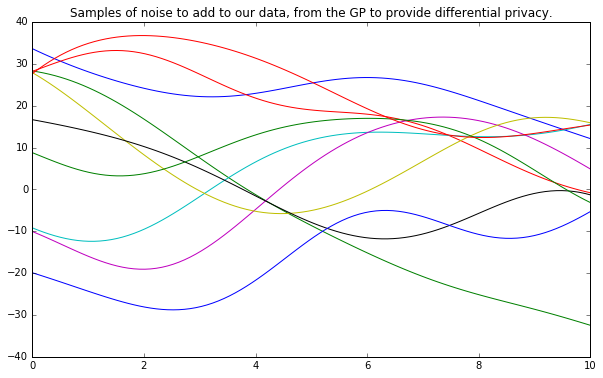

In [2]:
Nout = 100
x = np.linspace(0,10,Nout)
x = x[:,None]
for i in range(10):
    G = np.random.multivariate_normal(np.zeros(Nout),m.kern.K(x)).reshape(-1,1)
    plot(x,G)
plt.title('Samples of noise to add to our data, from the GP to provide differential privacy.')

Let's add a sample to the original function and see the result,...

But wait! The above samples are far above the 0 to 1 range. This is because the kernels in GPy have a constant multiplied to each. This we should remove? **TO DO???** As we're assuming $0<k(.,.)<1$.

 /home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning:covariance is not positive-semidefinite.


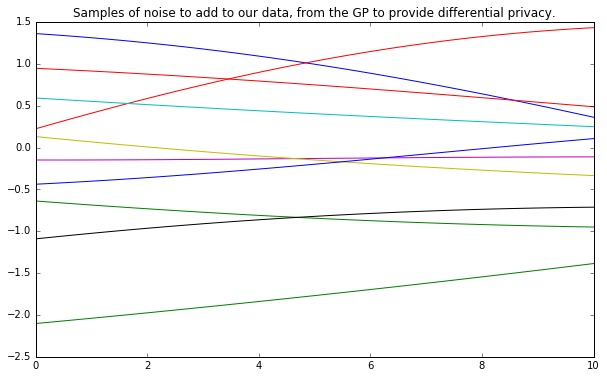

In [56]:
Nout = 100
x = np.linspace(0,10,Nout)
x = x[:,None]
for i in range(10):
    G = np.random.multivariate_normal(np.zeros(Nout),m.kern.K(x)/m.kern.variance).reshape(-1,1)
    plot(x,G)
plt.title('Samples of noise to add to our data, from the GP to provide differential privacy.')

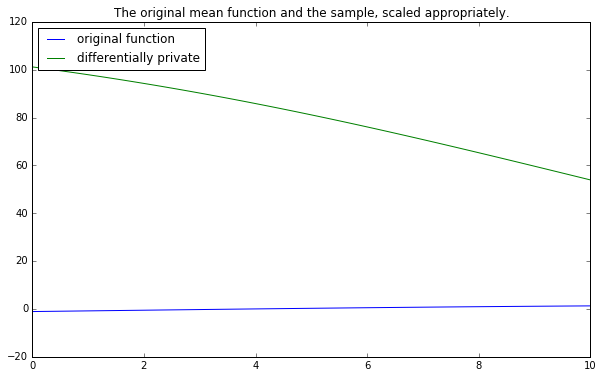

In [59]:

ypred = m.predict(x)[0]
plot(x,ypred,label='original function')
delta = 2 * N * (max(ypred)-min(ypred)) ##!!!! THIS IS NOT DIFFERENTIALLY PRIVATE ACCESS TO ymax!
alpha = 1.0 #what's an acceptable level of epsilon? (and why am I using alpha not epsilon?)
beta = 0.01
c = np.sqrt(2*np.log(2/beta)) #c > sqrt(2 log (2/beta)) e.g. beta = 0.1, c = sqrt(2 log (2/0.1)) = sqrt(2 log (20)) = 2.45
scale = delta * c / alpha
plot(x,ypred+G*scale,label='differentially private')
plt.title('The original mean function and the sample, scaled appropriately.')
plt.legend(loc='upper left')

Unfortunately the noise completely dominates the result. Adding DP noise using the current bounds on the effect of $\mathbf{x_n}$ requires so much noise that the function's original shape is lost.

# 3. Differential Privacy and GPs, making the inputs private (second attempt)

Going back to this step;

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 = \sum_{i=1}^n \sum_{j=1}^n a_i a_j k(\mathbf{x}_i, \mathbf{x}_j) - 2 \sum_{i=1}^n \sum_{j=1}^n a_i a'_j k(\mathbf{x}_i, \mathbf{x}'_j) + \sum_{i=1}^n \sum_{j=1}^n a'_i a'_j k(\mathbf{x}'_i, \mathbf{x}'_j)$$

We originally noted that the kernels are all $\leq 1$. 

We later put a constraint on the nearnest of the values in $\mathbf{x}$. 

This means that most of the $k(.,.)$ terms will be nearer to zero. This will provide a smaller upper bound.

We first note that we've chosen the values in $\mathbf{x}$ and $\mathbf{x'}$ such that $-1 \leq a_i \leq 1 \;\;  \forall i$.

Thus we can note that:

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 \leq \sum_{i=1}^n \sum_{j=1}^n k(\mathbf{x}_i, \mathbf{x}_j)  + \sum_{i=1}^n \sum_{j=1}^n k(\mathbf{x}'_i, \mathbf{x}'_j)$$

It is noted that the bounds we are going to impose on $k(\mathbf{x}_i, \mathbf{x}_j)$ are the same as those we are going to impose on $k(\mathbf{x}'_i, \mathbf{x}'_j)$.

$$||f_D(\mathbf{x}) - f_D'(\mathbf{x})||^2 \leq 2 \sum_{i=1}^n \sum_{j=1}^n k(\mathbf{x}_i, \mathbf{x}_j)$$

### Upper bound on $\sum_{i=1}^\inf k(\mathbf{x},\mathbf{x}_i)$
I need to prove the following mathematically, but for now, numerically, we're interested in finding an upper bound on the infinite sum of all kernels.

We've constrained the inputs to be spaced at least $d$ apart. Formally;

$$\forall i,j : i \neq j, ||\mathbf{x}_i-\mathbf{x}_j|| \geq d$$

So what is $\sum_{i=1}^\inf k(\mathbf{x},\mathbf{x}_i)$?

Below I've numerically considered a (1d) case with many inputs, spaced $d$ apart.

 /home/lionfish/anaconda/lib/python2.7/site-packages/numpy/linalg/linalg.py:1729: RuntimeWarning:overflow encountered in det
 /home/lionfish/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: ComplexWarning:Casting complex values to real discards the imaginary part


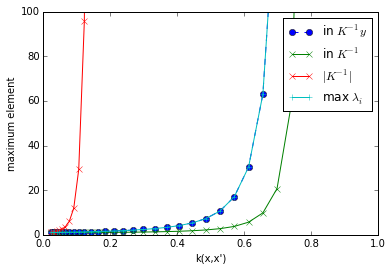

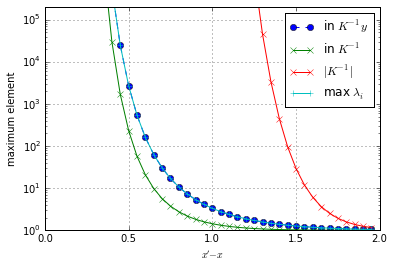

In [6]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)

def k(a,b): 
    a = a[:,None]
    b = b[:,None]
    a1 = a.repeat(b.shape[0],axis=1)
    b1 = b.repeat(a.shape[0],axis=1)
    return np.exp(-(a1.T-b1)**2)

idx = 0
dists = np.arange(0.25,2,0.05)
results_Gy = np.zeros_like(dists) #biggest value in Gy
results_G = np.zeros_like(dists)  #biggest value in G
results_Gdet = np.zeros_like(dists)
results_Gmaxeig = np.zeros_like(dists)
for dist in dists:
    #x = np.array([0,dist,dist*2,dist*3,dist*4,dist*5,dist*6,dist*7])
    x = np.arange(0,300*dist,dist)
    K = k(x,x)
    G = np.linalg.inv(K)
    checkerboard = np.zeros_like(G)
    for i in range(checkerboard.shape[0]):
        for j in range(checkerboard.shape[1]):
            checkerboard[i,j]=1-2*((i+j) % 2)
    det = np.linalg.det(K)
    cf = np.multiply(det*G,checkerboard)
    results_Gy[idx] = np.max(np.sum(np.abs(G),axis=0))
    results_G[idx] = np.max(G)
    results_Gdet[idx] = np.linalg.det(G)
    evals, _ = np.linalg.eig(G)
    results_Gmaxeig[idx] = np.max(evals)
    idx = idx + 1
    
import matplotlib.pyplot as plt
%matplotlib inline
kervals= k(np.array([0]),dists)
#plt.plot(dists,results)
plt.plot(kervals,results_Gy,'--o',label='in $K^{-1}y$')
plt.plot(kervals,results_G,'-x',label='in $K^{-1}$')
plt.plot(kervals,results_Gdet,'-x',label='$|K^{-1}|$')
plt.plot(kervals,results_Gmaxeig,'-+',label='max $\lambda_i$')

plt.xlabel('k(x,x\')')
plt.legend(loc='upper left')
plt.ylabel('maximum element')
plt.legend()
plt.ylim([0,100])
plt.figure()
plt.semilogy(dists,results_Gy,'--o',label='in $K^{-1}y$')
plt.semilogy(dists,results_G,'-x',label='in $K^{-1}$')
plt.semilogy(dists,results_Gdet,'-x',label='$|K^{-1}|$')
plt.semilogy(dists,results_Gmaxeig,'-+',label='max $\lambda_i$')

plt.xlabel('$x\'-x$')
plt.ylabel('maximum element')
plt.plot([0,2],[1,1])
plt.legend(loc='upper right')
plt.ylim([0,200000])
plt.xlim([0,2])
plt.grid()

So to summarise so far, we've selected the $\mathbf{y}$ vector, in which the elements are $1$s and $-1$s, so that the product $K^{-1}\mathbf{y}$ is maximised.

For an infinite number of inputs, for the 1d case, the worst case value of $K^{-1}\mathbf{y}$ appears to be equal to the maximum eigenvalue.

If we multiply $K^{-1}\mathbf{z}$, where $\mathbf{z}$ is a unit vector in the direction of the associated eigenvector. Then $\mathbf{z}$ will be scaled by this eigenvalue. No unit vector will be scaled more. The eigenvectors are orthogonal (and unit length). The following logic requires that one notes that the eigenvectors of $K$ and $K^{-1}$ are equal.

**WRONG:**
First imagine there are just two inputs. Imagine the ellipse formed by the covariance between these two inputs. The variance of the inputs are equal (as the two kernels are identical). Assume for simplicity that the covariance is positive between the two inputs. This means that the ellipse's major axis is in the [1,1] direction (at $45^\circ$). The minor axis is therefore in the [1,-1] direction. Now imagine a third point is added. This also has an equal variance to the other two points, so the major axis points in the [1,1,1] direction.

**CORRECT (MAYBE)**
I think that as the number of inputs increases, the eigenvectors start to roughly point in the 

In general, for any number of dimensions the eigenvectors of the covariance matrix point in directions such as [1,-1,...1,1,-1] etc (note scaled to have unit length). This is important as we are interested in $\mathbf{y}$ in which the values are 1s or -1s (i.e. the most extreme values), any value of $\mathbf{y}$ smaller than that will have a smaller total. By selecting $\mathbf{y}$ to face in the direction of the eigenvector with the largest eigenvalue, no flipping of sign of any $y_i$ will make the result of $K^{-1}\mathbf{y}$ larger.

Nothing in the logic above is restricted to inputs in one dimension, so I assume this applies to inputs of any dimensionality.

Summary: **The worst case value of $K^{-1}\mathbf{y}$ appears to be equal to the maximum eigenvalue.**

The maximum eigenvalue of $K^{-1}$ is equal to the minimum eigenvalue of $K$.

